---
# **Estudio del cálculo de la Prima del Seguro**

*Prefacio : Nuestra tarea consiste en encontrar el mejor entrenamiento de regresiones para calcular la prima del seguro*

---

## Declaración de módulos
---

En primer lugar, vamos a importar algunos módulos comunes. También comprobamos que Python 3.5 o posterior está instalado (aunque Python 2.x puede funcionar, está obsoleto por lo que es **altamente** recomendable utilizar Python 3 en su lugar), así como Scikit-Learn ≥0.20.

También agregaremos una librería (warnings) para evitar los molestos mensajes de advertencia(Futurewarnings).

In [194]:
# Se requiere Python ≥ 3.5
import sys
assert sys.version_info >= (3, 5)

# Se requiere Scikit-Learn ≥ 0.20
import sklearn
assert sklearn.__version__ >= "0.20"

# Otros imports
import numpy as np
import os

# Importamos la librería Pandas para administar Dataframes
import pandas as pd

# la línea que sigue, sólo en Colab ...
# %matplotlib inline
# Importamos librería MatPlotLib
import matplotlib as mpl
import matplotlib.pyplot as plt

# tamaño del texto en las etiquetas por defecto
mpl.rc('axes',  labelsize=15)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)

# Importa la librería que va a posibilitar evitar que salgan los molestos mensajes de advertencia
import warnings

Configuración de las Advertencias "Futurewarning"

In [195]:
# configuración para eviatar que aparezcan las advertencias "FutureWarnings"
warnings.filterwarnings("ignore", category=FutureWarning)

## Importacion de Datos
---

Definimos la función que importará los datos de un archivo CSV a un Dataframe de Pandas

In [204]:
INSURANCE_PATH = os.path.join("datasets", "insurance");

def load_insurance_data(insurance_path):
    csv_path = os.path.join(insurance_path, "insurance.csv")
    return pd.read_csv(csv_path)

Llamamos a la función de importación de datos y los importamos a la variable "insurance"

In [205]:
insurance = load_insurance_data(INSURANCE_PATH)

Comprobamos el estado de los Datos, mediante una revisión de las primeras filas

In [206]:
insurance.head()

,age,sex,bmi,children,smoker,region,charges
0,19.0,female,27.900,0,yes,southwest,16884.92400
1,18.0,male,33.770,1,no,southeast,1725.55230
2,28.0,male,33.000,3,no,southeast,4449.46200
3,33.0,male,22.705,0,no,northwest,21984.47061
4,32.0,male,28.880,0,no,northwest,3866.85520


Comprobamos la información del Dataframe

In [207]:
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   float64
 1   sex       1338 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(3), int64(1), object(3)
memory usage: 73.3+ KB


Comprobamos un resumen descriptivo general del Dataframe

In [208]:
insurance.describe()

,age,bmi,children,charges
count,1337.000000,1337.000000,1338.000000,1338.000000
mean,39.208676,30.664589,1.094918,13270.422265
std,14.055088,6.100313,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.290000,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.700000,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Revisamos el estado de los datos : Gestión de los NaN del DataSet
---

Comprobación del número de NaN por categoría

In [209]:
# De forma global
insurance.isna().sum()

age         1
sex         0
bmi         1
children    0
smoker      1
region      0
charges     0
dtype: int64

Podemos ver como tenemos varios NaN repartidos
* age 1
* bmi 1
* smoker 1

Realizamos una copia del dataset por si fuera necesario recuperar el original

In [210]:
insurance_backup = insurance.copy()

*En el caso de la edad (age), pondremos la media*

In [211]:
# Hallamos la media redondeada a años
media_age = round(insurance["age"].mean(),0)
print("La media redondeada a años es: ", round(insurance["age"].mean(),0))
# Localizamos el índice del NaN
lista_NaN_age = list(insurance.loc[pd.isna(insurance["age"]), :].index)
print("Lista de los índices con NaN : ", list(insurance.loc[pd.isna(insurance["age"]), :].index))
# Cambiamos el valor de los índice para la columna añoas por la media
for x in lista_NaN_age:
    insurance.loc[x,'age']=media_age

#Revisamos resultados 
print("Después de los cambios, el número de los NaN en la columna 'age' es de : ", insurance["age"].isna().sum())


La media redondeada a años es:  39.0
Lista de los índices con NaN :  [750]
Después de los cambios, el número de los NaN en la columna 'age' es de :  0


*En el caso del índice de masa corporal (bmi), pondremos la media*

In [214]:
# Hallamos la media redondeada a tres decimales
media_bmi = round(insurance["bmi"].mean(),3)
print("La media redondeada de índice de masa corporal es: ", round(insurance["bmi"].mean(),3))
# Localizamos el índice del NaN
lista_NaN_bmi = list(insurance.loc[pd.isna(insurance["bmi"]), :].index)
print("Lista de los índices con NaN : ", list(insurance.loc[pd.isna(insurance["bmi"]), :].index))
# Cambiamos el valor de los índice para la columna añoas por la media
for x in lista_NaN_bmi:
    insurance.loc[x,'bmi']=media_bmi

#Revisamos resultados 
print("Después de los cambios, el número de los NaN en la columna 'bmi' es de: ", insurance["bmi"].isna().sum())

La media redondeada de índice de masa corporal es:  30.665
Lista de los índices con NaN :  [1337]
Después de los cambios, el número de los NaN en la columna 'bmi' es de:  0


*En el caso de fumador/no fumador, miraremos cual es la opción mayoritaria y pondremos esa en el caso concreto de NaN*

In [212]:
# Revisaremos las dos opciones, y las contaremos
print("El número de valores de fumadores y no fumadores es :\n", insurance["smoker"].value_counts())
# Vemos que la opción mayoritaria es NO fumador, por lo que cambiaremos el NaN por un "no"
# Localizamos el índice del NaN
lista_NaN_smoker = list(insurance.loc[pd.isna(insurance["smoker"]), :].index)
print("Lista de los índices con NaN : ", list(insurance.loc[pd.isna(insurance["smoker"]), :].index))
# Cambiamos el valor de los índice para la columna añoas por la media
for x in lista_NaN_smoker:
    insurance.loc[x,'smoker']="no"

#Revisamos resultados 
print("Después de los cambios, el número de los NaN en la columna 'smoker' es de : ", insurance["smoker"].isna().sum())


El número de valores de fumadores y no fumadores es :
 no     1063
yes     274
Name: smoker, dtype: int64
Lista de los índices con NaN :  [681]
Después de los cambios, el número de los NaN en la columna 'smoker' es de :  0


Finalmente, revisamos la lista total de NaN por categoría, para asegurarnos que no queda ninguno sin tratar.

In [215]:
# Revisamos de nuevo los NaN de forma global
insurance.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Revisión y tratamiento de las columnas categorizadas : Sex, Smoker y Region
---


Revisaremos las tres categorías, agregando la columna a una variable que usaremos posteriormente, y revisaremos el tipo de las categorías y sus valores

### Sex

In [217]:
# agregamos la columna a una variable
cat_sexo = insurance[ ["sex"] ]

# Revisamos el contenido de la columna
insurance["sex"].value_counts()


male      676
female    662
Name: sex, dtype: int64

### Smoker

In [218]:
# agregamos la columna a una variable
cat_fumador = insurance[ ["smoker"] ]

# Revisamos el contenido de la columna
insurance["smoker"].value_counts()


no     1064
yes     274
Name: smoker, dtype: int64

### Region

In [219]:
# agregamos la columna a una variable
cat_region = insurance[ ["region"] ]

# Revisamos el contenido de la columna
insurance["region"].value_counts()



southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

Podemos observar que son columnas categarizadas, que para el entrenamiento no pueden existir, por lo que necesitamos pasar de columnas categorizadas a otro tipo de expresión como por ejemplo a la división de las categorías en nuevas columnas y poniendo un 0 cuando no se cumpla la condición de la categoría y un "1" cuando sí.

De esta forma no estaremos añadiendo información al Dataset, y nos permitirá el estudio y el entrenamiento del modelo.

## Uso de OneHotEncoder para la gestión de las cloumnas categorizadas
---

OneHotencoder nos permitirá pasar las categorías a diferentes columnas por valor de categoría y agragarle "0" y "1" en cada caso.

Ante de nada realizaremos un Backup de los datos por si necesitáramos volver al estado anterior

In [220]:
# Haremos una copia para ver los resultados 
insurance_backup = insurance.copy()

Crearemos una nueva variable con el Dataframe Normalizado llamdo "insurance_norm"

In [221]:
insurance_norm = insurance.copy()

Llamamos a la librería "OneHotEncoder" de Sklearn

In [222]:
# Declaramos la librería OneHotEncoder de sklearn
from sklearn.preprocessing import OneHotEncoder

Usamos el método con cada una de las columnas categóricas, empezando por


### SEXO

In [223]:
sexo_encoder =OneHotEncoder(sparse=False)
# para la categoria Sexo (male/female)
sexo_cat_1hot = sexo_encoder.fit_transform(cat_sexo)

sexo_cat_1hot

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [224]:
# Aquí tendremos los nombre de las categorías
sexo_encoder.categories_

[array(['female', 'male'], dtype=object)]

In [225]:

# Ahora sustituiremos la columna Sexo , por las de OneHotEncoder
insurance_norm.reset_index(drop=False, inplace=True)
insurance_norm=insurance_norm.join(pd.DataFrame(sexo_cat_1hot, columns=[cat for cat in sexo_encoder.categories_[0]]))
# Borraremos la columna categorizada, así como el index que se añadió al realizar el join 
insurance_norm=insurance_norm.drop(["sex","index"], axis=1)
# Mostramos el resultado
insurance_norm.info()
insurance_norm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   smoker    1338 non-null   object 
 4   region    1338 non-null   object 
 5   charges   1338 non-null   float64
 6   female    1338 non-null   float64
 7   male      1338 non-null   float64
dtypes: float64(5), int64(1), object(2)
memory usage: 83.8+ KB


,age,bmi,children,smoker,region,charges,female,male
0,19.0,27.900,0,yes,southwest,16884.92400,1.0,0.0
1,18.0,33.770,1,no,southeast,1725.55230,0.0,1.0
2,28.0,33.000,3,no,southeast,4449.46200,0.0,1.0
3,33.0,22.705,0,no,northwest,21984.47061,0.0,1.0
4,32.0,28.880,0,no,northwest,3866.85520,0.0,1.0


### FUMADOR

In [226]:
fumador_encoder = OneHotEncoder(sparse=False)
# para la categoria Fumador (no/yes)
fumador_cat_1hot = fumador_encoder.fit_transform(cat_fumador)

insurance_norm.reset_index(drop=False, inplace=True)
insurance_norm=insurance_norm.join(pd.DataFrame(fumador_cat_1hot, columns=[cat for cat in fumador_encoder.categories_[0]]))
# Borraremos la columna categorizada, así como el index que se añadió al realizar el join
insurance_norm=insurance_norm.drop(["smoker","index"], axis=1)

# Mostramos el resultado
insurance_norm.info()
insurance_norm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   float64
 1   bmi       1338 non-null   float64
 2   children  1338 non-null   int64  
 3   region    1338 non-null   object 
 4   charges   1338 non-null   float64
 5   female    1338 non-null   float64
 6   male      1338 non-null   float64
 7   no        1338 non-null   float64
 8   yes       1338 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 94.2+ KB


,age,bmi,children,region,charges,female,male,no,yes
0,19.0,27.900,0,southwest,16884.92400,1.0,0.0,0.0,1.0
1,18.0,33.770,1,southeast,1725.55230,0.0,1.0,1.0,0.0
2,28.0,33.000,3,southeast,4449.46200,0.0,1.0,1.0,0.0
3,33.0,22.705,0,northwest,21984.47061,0.0,1.0,1.0,0.0
4,32.0,28.880,0,northwest,3866.85520,0.0,1.0,1.0,0.0


En este caso también le cambiaremos el nombre(label) de las columnas , para un mejor entendimiento

In [227]:
# Cambiamos el nombre d elas columnas para entenderlo mejor
insurance_norm=insurance_norm.rename(columns={"no":"no smoker"});
insurance_norm=insurance_norm.rename(columns={"yes":"smoker"});

# Revisamos cambios 
insurance_norm.head()

,age,bmi,children,region,charges,female,male,no smoker,smoker
0,19.0,27.900,0,southwest,16884.92400,1.0,0.0,0.0,1.0
1,18.0,33.770,1,southeast,1725.55230,0.0,1.0,1.0,0.0
2,28.0,33.000,3,southeast,4449.46200,0.0,1.0,1.0,0.0
3,33.0,22.705,0,northwest,21984.47061,0.0,1.0,1.0,0.0
4,32.0,28.880,0,northwest,3866.85520,0.0,1.0,1.0,0.0


In [228]:
# para la categoria Region (southeast/southwest/northwest/northeast)
region_encoder = OneHotEncoder(sparse=False) 
region_cat_1hot = region_encoder.fit_transform(cat_region)

insurance_norm.reset_index(drop=False, inplace=True)
insurance_norm=insurance_norm.join(pd.DataFrame(region_cat_1hot, columns=[cat for cat in region_encoder.categories_[0]]))
# Borraremos la columna categorizada, así como el index que se añadió al realizar el join
insurance_norm=insurance_norm.drop(["region","index"], axis=1)

# Mostramos el resultado
insurance_norm.info()
insurance_norm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   float64
 1   bmi        1338 non-null   float64
 2   children   1338 non-null   int64  
 3   charges    1338 non-null   float64
 4   female     1338 non-null   float64
 5   male       1338 non-null   float64
 6   no smoker  1338 non-null   float64
 7   smoker     1338 non-null   float64
 8   northeast  1338 non-null   float64
 9   northwest  1338 non-null   float64
 10  southeast  1338 non-null   float64
 11  southwest  1338 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 125.6 KB


,age,bmi,children,charges,female,male,no smoker,smoker,northeast,northwest,southeast,southwest
0,19.0,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18.0,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28.0,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33.0,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32.0,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


Revisamos el resultado final

In [230]:
insurance_norm.head()

,age,bmi,children,charges,female,male,no smoker,smoker,northeast,northwest,southeast,southwest
0,19.0,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18.0,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28.0,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33.0,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32.0,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0


## Revisión de los histogramas de las columnas
---

Realizamos una visualización de los histogramas de los datos, para tener una idea de su cantidad, dispersión ,etc...

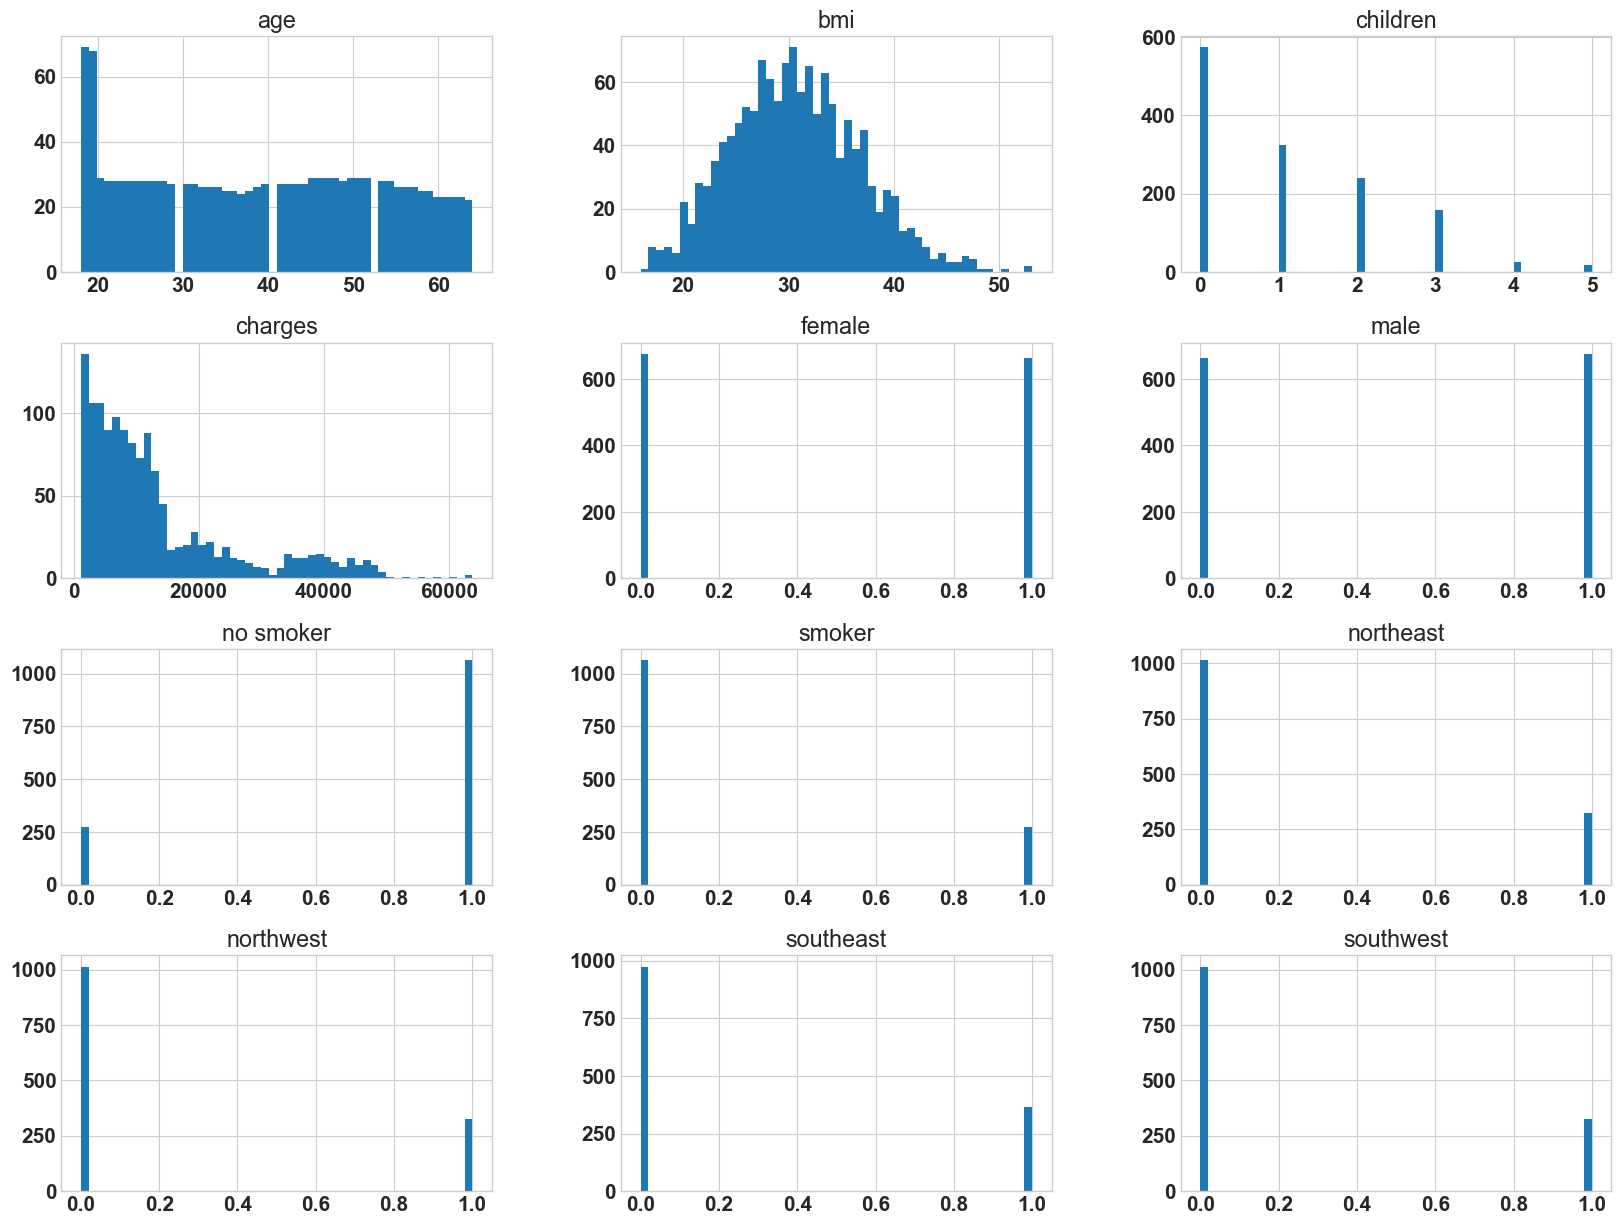

In [125]:
insurance_norm.hist(bins=50, figsize =(20,15))
plt.show()

Podemos ver que:
- Edad : Hay una gran concentración de muestras en edades de 18 a 20 años
- BMI(Índice de Masa Corporal) : Tiene una dispersión normal (Campana de Gauss)
- Hijos : Existen más concentración de muestras cuantos menos hijos, siendo "0" la mayor de ellas
- Cargos : Hay una gran concentración de muestras en las más bajas hasta 15.000
- Sexo : Igual número (aproximado) de hombre y mujeres
- Fumadores : Mucha más concentración de NO fumadores ( casi tres veces más )
- Región : Aproximadamente numero igual de muestras en cada region

## Estudio numérico de la correlación entre los datos para obtener información relevante
---

### Buscando correlaciones

Declaramos la libreria de "Seaborn" para las visualizaciones

In [234]:
# Importamos librería "Seaborn" para la visualización que es como un MatPlotLib con "esteriodes"
import seaborn as sns 

Configuración de las visualizaciones de "Seaborn"

In [235]:
# Configuramos visualizaciones con Seaborn
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['font.size'] =14
plt.rcParams['font.weight']= 'bold'
plt.style.use('seaborn-whitegrid')

Mostramos las correlaciones en formato del modelo Normalizado y NO normalizado

Aquí nos damos cuenta de la necesidad de la normalización del modelo para que las correlaciones puedan ser medidas

In [255]:
corr_matrix = insurance.corr()
corr_matrix["charges"].sort_values(ascending=False)

charges     1.000000
age         0.299066
bmi         0.198602
children    0.067998
Name: charges, dtype: float64

In [245]:
corr_matrix

,age,bmi,children,charges
age,1.000000,0.109505,0.042373,0.299066
bmi,0.109505,1.000000,0.012582,0.198602
children,0.042373,0.012582,1.000000,0.067998
charges,0.299066,0.198602,0.067998,1.000000


In [254]:
corr_matrix_norm = insurance_norm.corr()
corr_matrix_norm["charges"].sort_values(ascending=False)

charges      1.000000
smoker       0.787251
age          0.299066
bmi          0.198602
southeast    0.073982
children     0.067998
male         0.057292
northeast    0.006349
northwest   -0.039905
southwest   -0.043210
female      -0.057292
no smoker   -0.787251
Name: charges, dtype: float64

In [256]:
corr_matrix_norm

,age,bmi,children,charges,female,male,no smoker,smoker,northeast,northwest,southeast,southwest
age,1.000000,0.109505,0.042373,0.299066,0.020964,-0.020964,0.024809,-0.024809,0.002415,-0.000468,-0.011468,0.009956
bmi,0.109505,1.000000,0.012582,0.198602,-0.046175,0.046175,-0.004136,0.004136,-0.138270,-0.135654,0.269912,-0.006316
children,0.042373,0.012582,1.000000,0.067998,-0.017163,0.017163,-0.007673,0.007673,-0.022808,0.024806,-0.023066,0.021914
charges,0.299066,0.198602,0.067998,1.000000,-0.057292,0.057292,-0.787251,0.787251,0.006349,-0.039905,0.073982,-0.043210
female,0.020964,-0.046175,-0.017163,-0.057292,1.000000,-1.000000,0.076185,-0.076185,0.002425,0.011156,-0.017117,0.004184
male,-0.020964,0.046175,0.017163,0.057292,-1.000000,1.000000,-0.076185,0.076185,-0.002425,-0.011156,0.017117,-0.004184
no smoker,0.024809,-0.004136,-0.007673,-0.787251,0.076185,-0.076185,1.000000,-1.000000,-0.002811,0.036945,-0.068498,0.036945
smoker,-0.024809,0.004136,0.007673,0.787251,-0.076185,0.076185,-1.000000,1.000000,0.002811,-0.036945,0.068498,-0.036945
northeast,0.002415,-0.138270,-0.022808,0.006349,0.002425,-0.002425,-0.002811,0.002811,1.000000,-0.320177,-0.345561,-0.320177
northwest,-0.000468,-0.135654,0.024806,-0.039905,0.011156,-0.011156,0.036945,-0.036945,-0.320177,1.000000,-0.346265,-0.320829


Mostramos las mismas correlaciones con el modelo gráfico de Seaborn de "Heatmap"

<AxesSubplot: >

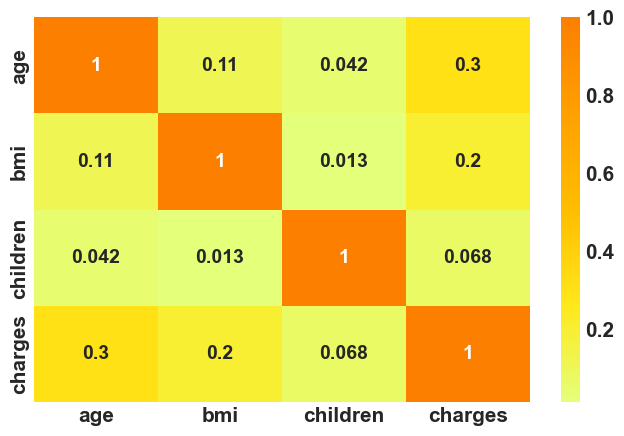

In [247]:
corr = insurance.corr()
sns.heatmap(corr, cmap = 'Wistia', annot= True)

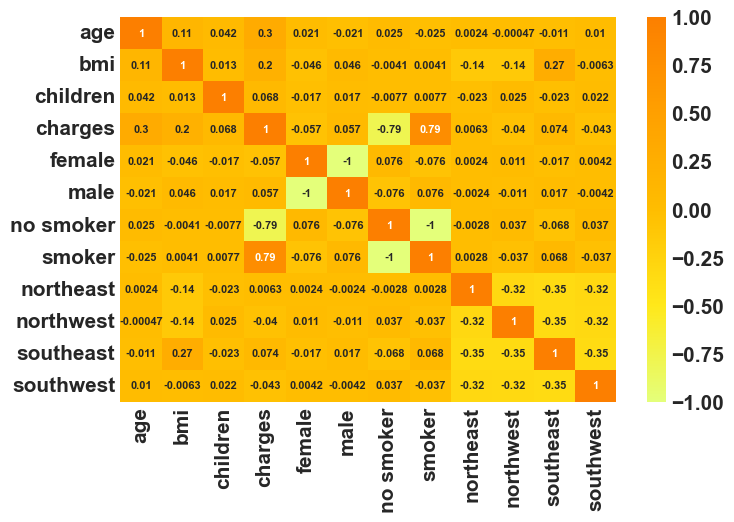

In [248]:
corr_norm = insurance_norm.corr()
# Reduciremos el tamaño de fuente para este gráfico (y lo volveremos a dejar como estaba) por el tamaño de celdas
plt.rcParams['font.size'] =8
sns.heatmap(corr_norm, cmap = 'Wistia', annot= True)
plt.rcParams['font.size'] =14

### Conclusiones Preliminares
---

Podemos observar que en las correlaciones detaca que:
- Existe una correlación muy grande entre Prima y Fumadores 0.787251 ~0.8
- Seguida de una correlación menor con Prima y Edad 0.299066 ~0.3
- Con menos fuerza, tenemos una relación entre Prima y BMI 0.198602 ~0.2
- También tenemos una curiosa relacion entre la region "Southeast" y BMI de un nada despreciable 0.27
- Por último podemos destacar una débil relación entre Edad y BMI de 0.11 

## Visualización de los datos para obtener información relevante
---

Usaremos la visualización de "Scatter Matrix" de Pandas, para revisar las posibles relaciones lineales entre categorías

Para ello llamamos a la librería y agregamos algunas de las categorías numericas

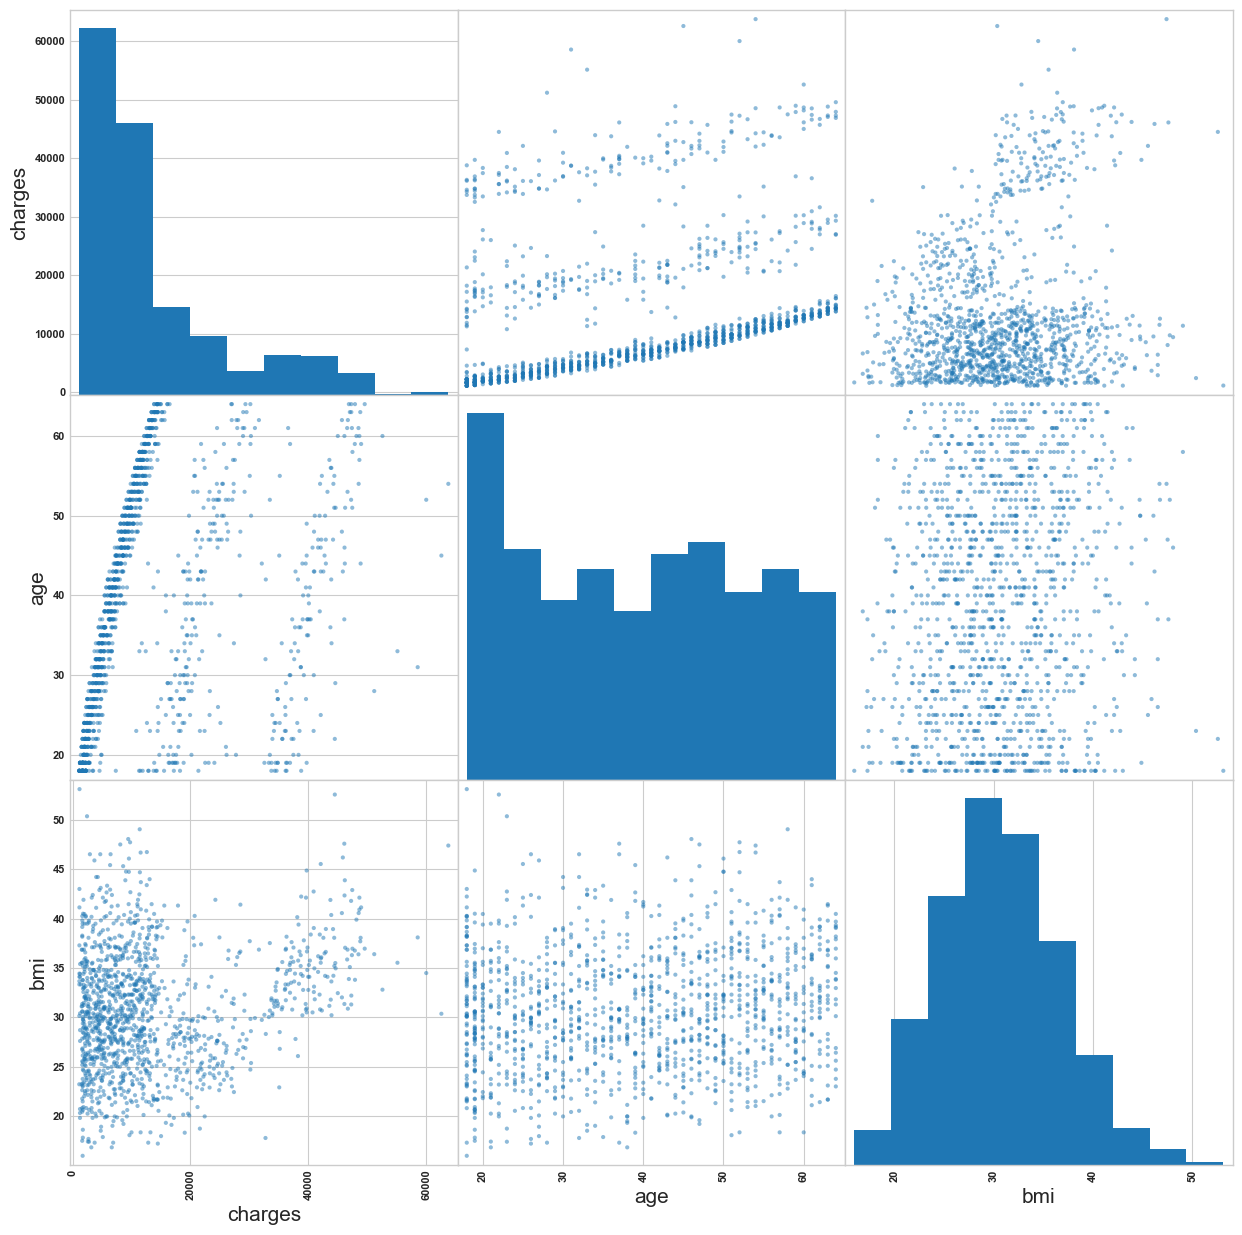

In [258]:
from pandas.plotting import scatter_matrix;

attributes = ["charges","age", "bmi"]

scatter_matrix(insurance_norm[attributes], figsize=(15,15) );

### Revisamos la correlación entre Prima de seguro y Edad, con colores para Fumadores
---

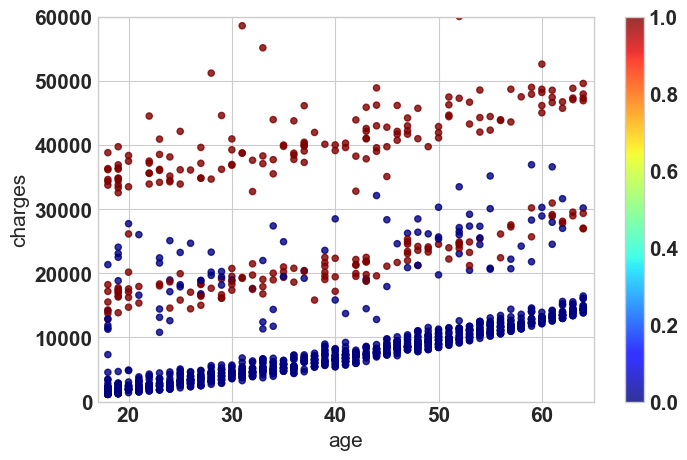

In [129]:

insurance_norm.plot(kind="scatter", 
             x= "age",
             y = "charges",
             c=insurance_norm["smoker"],
             cmap = plt.get_cmap("jet"),
             alpha=0.8)

plt.axis([17,65,0,60000]);

### Conclusión :

Podemos observar que existe una relación lineal positiva entre el precio de la prima del seguro y la edad.

En mayor medida entre los que fuman, llegando a pagar el doble e incluso el triple

---

### Revisamos la correlación entre Prima de seguro y BMI, con colores para Fumadores
---

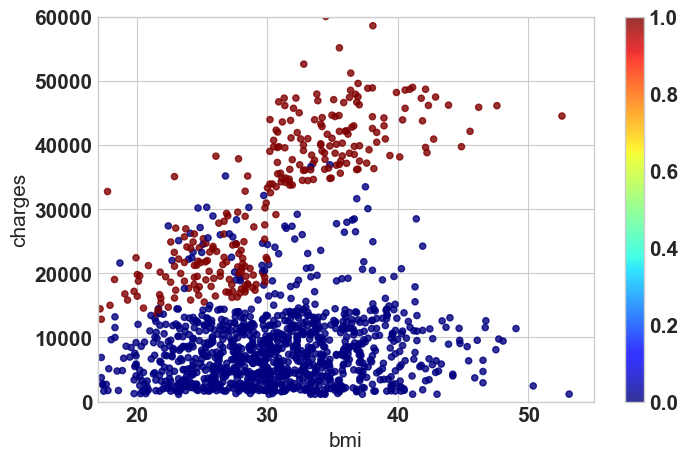

In [130]:

insurance_norm.plot(kind="scatter", 
             x= "bmi",
             y = "charges",
             c=insurance_norm["smoker"],
             cmap = plt.get_cmap("jet"),
             alpha=0.8)

plt.axis([17,55,0,60000]);

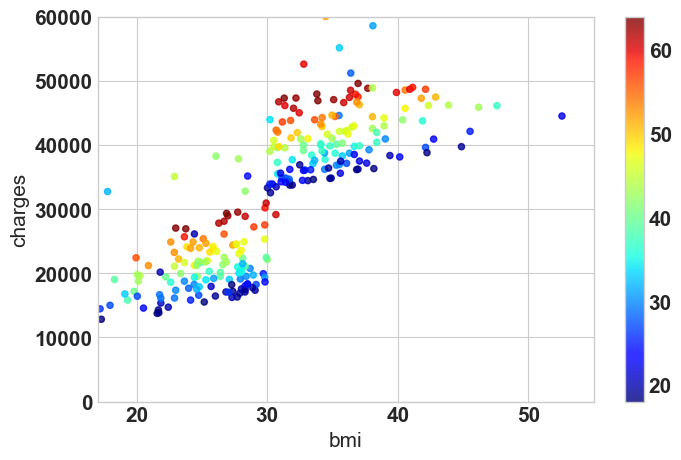

In [135]:
filter_smoker_norm.plot(kind="scatter", 
             x= "bmi",
             y = "charges",
             c=filter_smoker_norm["age"],
             cmap = plt.get_cmap("jet"),
             alpha=0.8)

plt.axis([17,55,0,60000]);

### Conclusión:
Podemos observar que existe una relación lineal positiva entre el precio de la prima del seguro y en mayor medida entre los que fuman, llegando a pagar el doble e incluso el triple
Podemos observar claramente que la edad juega un factor muy importante, y que la diferencia entre fumadores y no fumadores es muy grande.
También que la condición de estar por encima de un índice de bmi superior a 30, dispara la correlación lineal entre BMI y prima para los Fumadores

---

### Aplicamos un filtro de fumadores y no fumadores 
Como no podemos ver con claridad las clasificaciones binarias de las columnas categorizadas ni binarias, crearemos nuevos dataframes categorizados para usarlos con los gráficos , para ver la fuerte correlación entre fumadores y las cargas de seguro.

In [132]:
# Filtramos los fumadores
filter_smoker = insurance[(insurance['smoker']=='yes')]
filter_no_smoker = insurance[(insurance['smoker']=='no')]

filter_smoker_norm = insurance_norm[(insurance_norm['smoker']==1)]
filter_no_smoker_norm = insurance_norm[(insurance_norm['smoker']==0)]



### Agregamos una nueva columna separando los que tengan más y menos de 30 de BMI

In [131]:

insurance['BMI_below_30'] = np.where(insurance['bmi']<30,'yes', 'no') 
insurance_norm['BMI_below_30'] = np.where(insurance['bmi']<30, 1, 0) 


### Aplicamo un filtro sobre la masa corporal BMI <30 y >30

In [261]:
# Filtramos los fumadores
below30_bmi = filter_smoker[(filter_smoker['bmi']<30)]
upper30_bmi = filter_smoker[(filter_smoker['bmi']>=30)]

below30_bmi_norm = filter_smoker_norm[(filter_smoker_norm['bmi']<30)]
upper30_bmi_norm = filter_smoker_norm[(filter_smoker_norm['bmi']>=30)]

---

...............................................

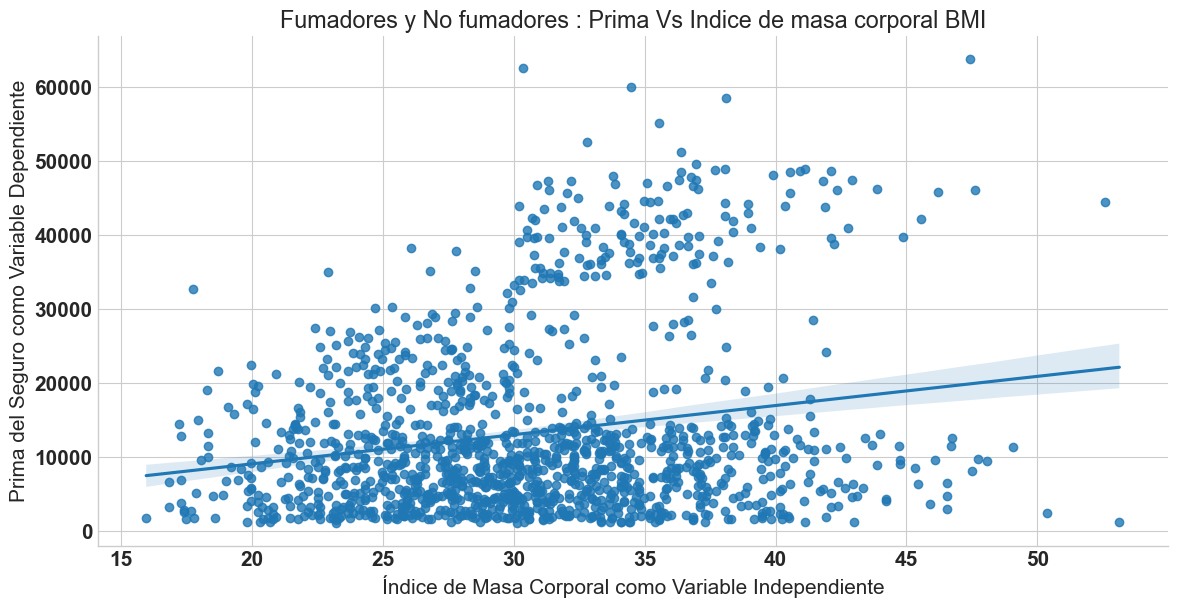

In [143]:
sns.lmplot(x='bmi',y='charges',data=insurance,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores y No fumadores : Prima Vs Indice de masa corporal BMI');


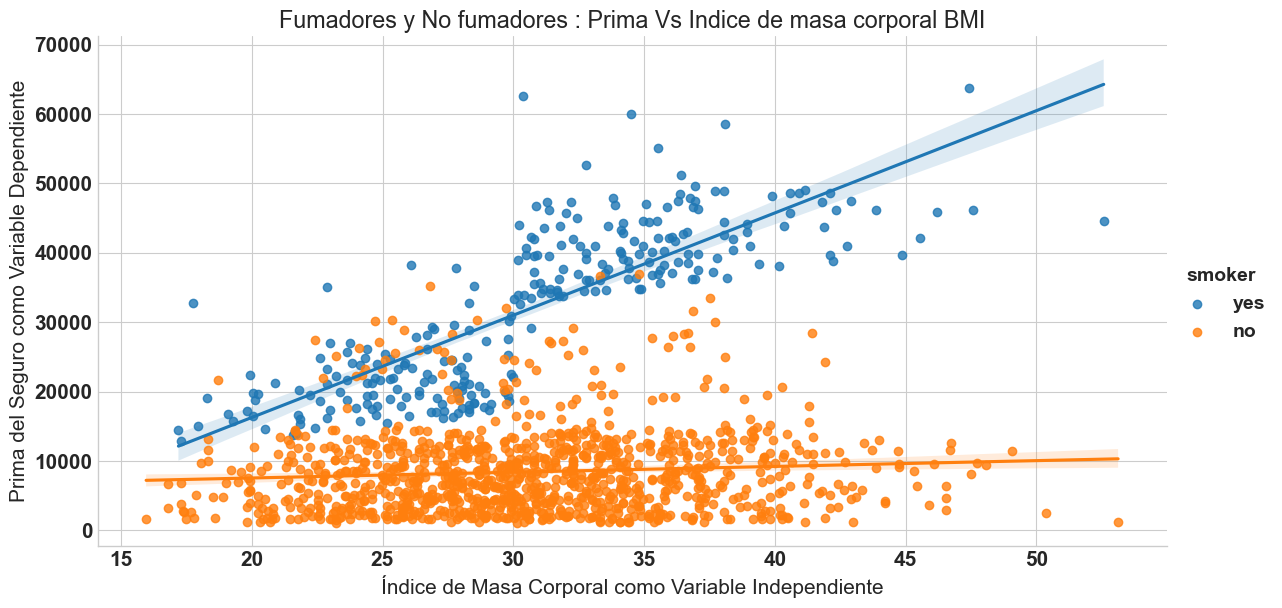

In [144]:

sns.lmplot(x='bmi',y='charges',hue='smoker',data=insurance,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores y No fumadores : Prima Vs Indice de masa corporal BMI');

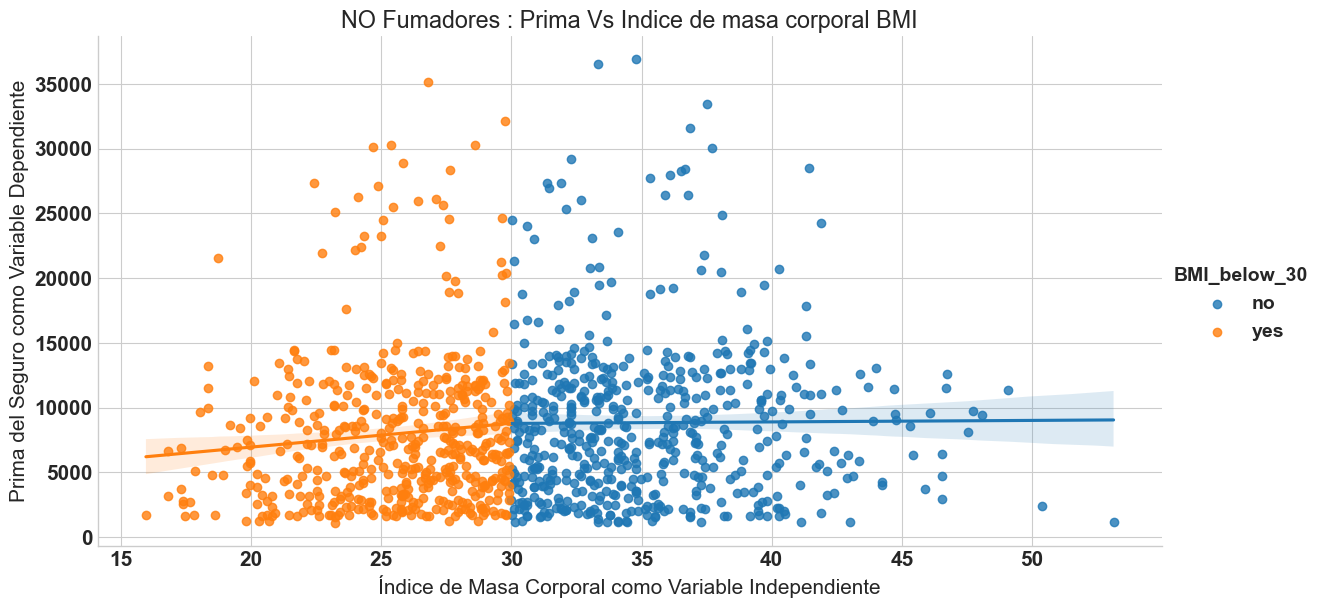

In [145]:
sns.lmplot(x='bmi',y='charges',hue='BMI_below_30',data=filter_no_smoker,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('NO Fumadores : Prima Vs Indice de masa corporal BMI');

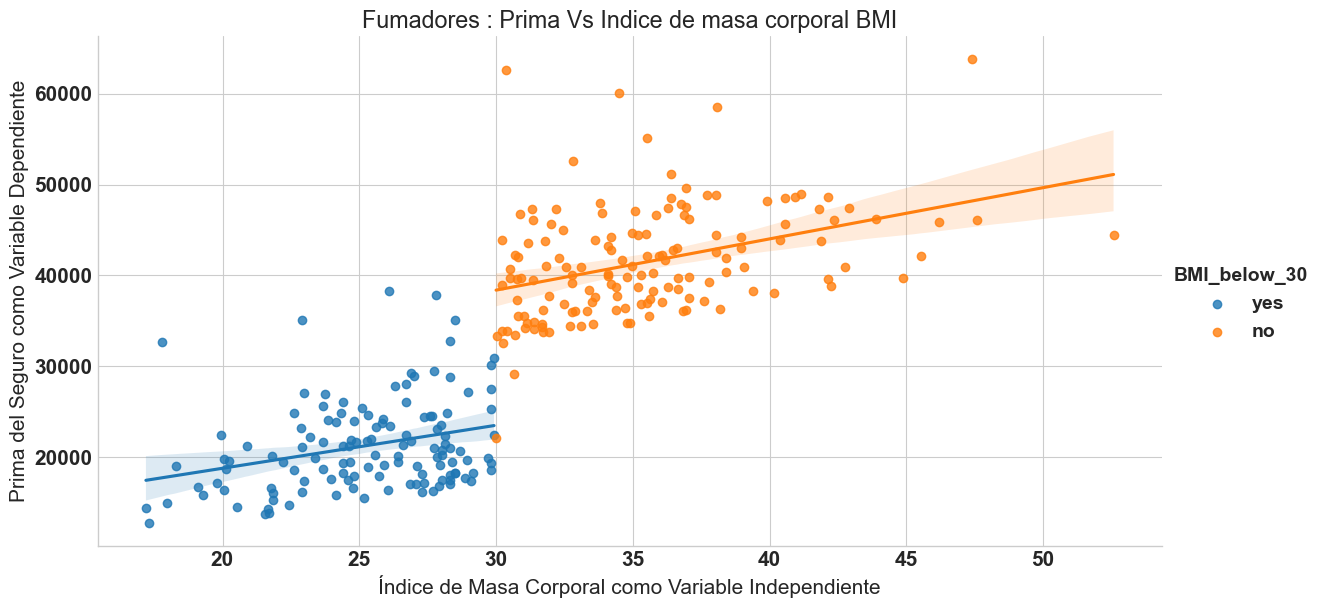

In [146]:
sns.lmplot(x='bmi',y='charges',hue='BMI_below_30', data=filter_smoker,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores : Prima Vs Indice de masa corporal BMI');

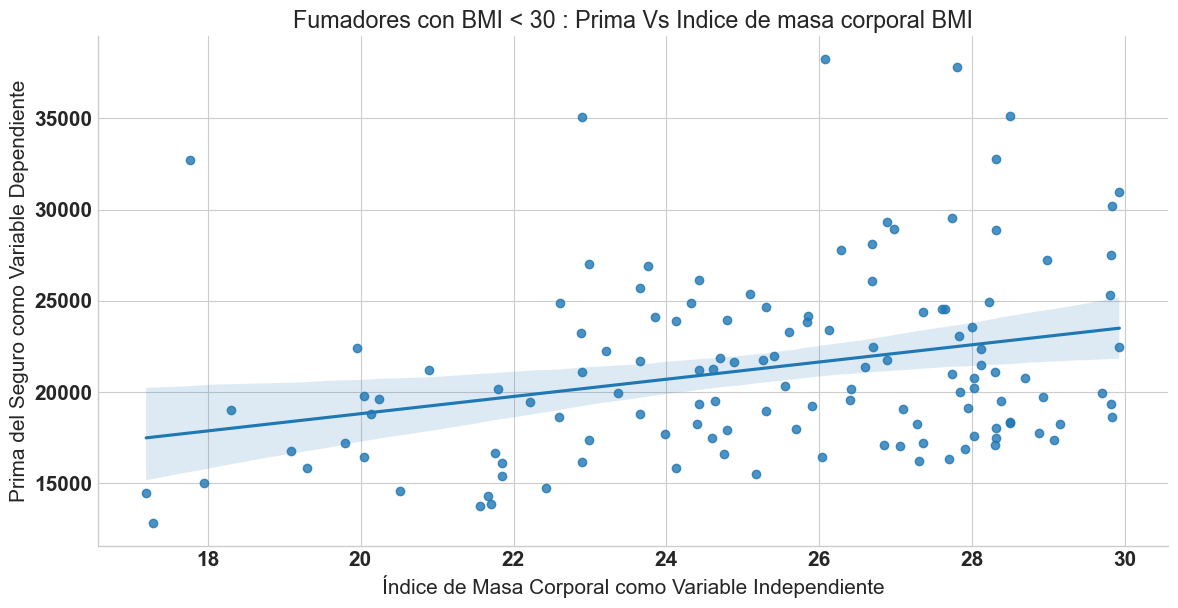

In [147]:
sns.lmplot(x='bmi',y='charges',data=below30_bmi,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores con BMI < 30 : Prima Vs Indice de masa corporal BMI');

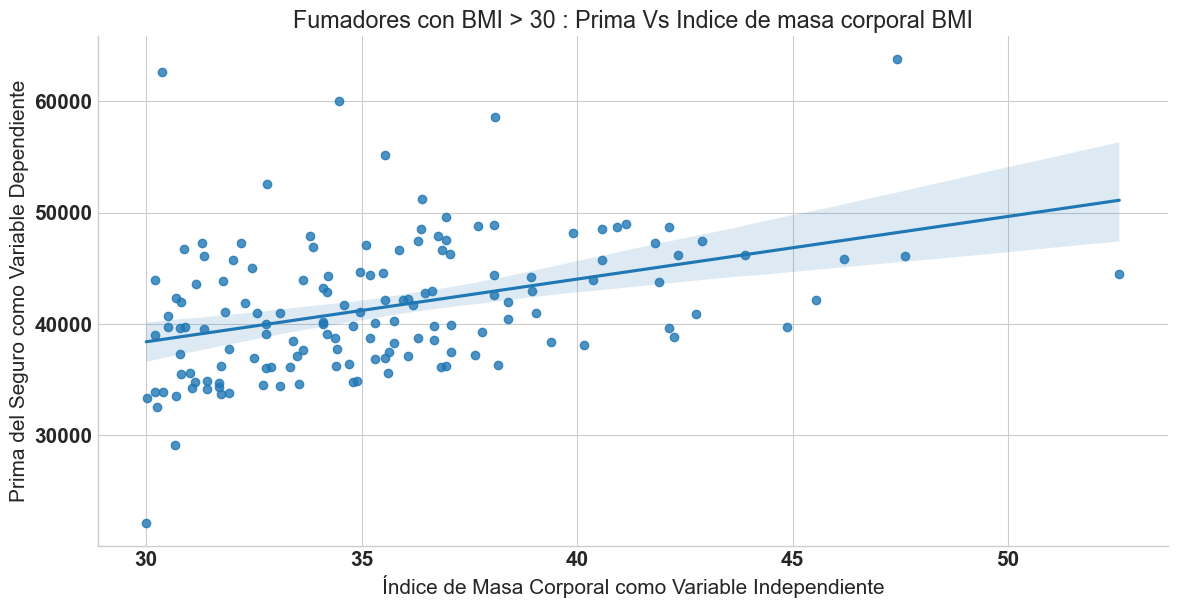

In [148]:
sns.lmplot(x='bmi',y='charges',data=upper30_bmi,aspect=2,height=6)
plt.xlabel('Índice de Masa Corporal como Variable Independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores con BMI > 30 : Prima Vs Indice de masa corporal BMI');

---

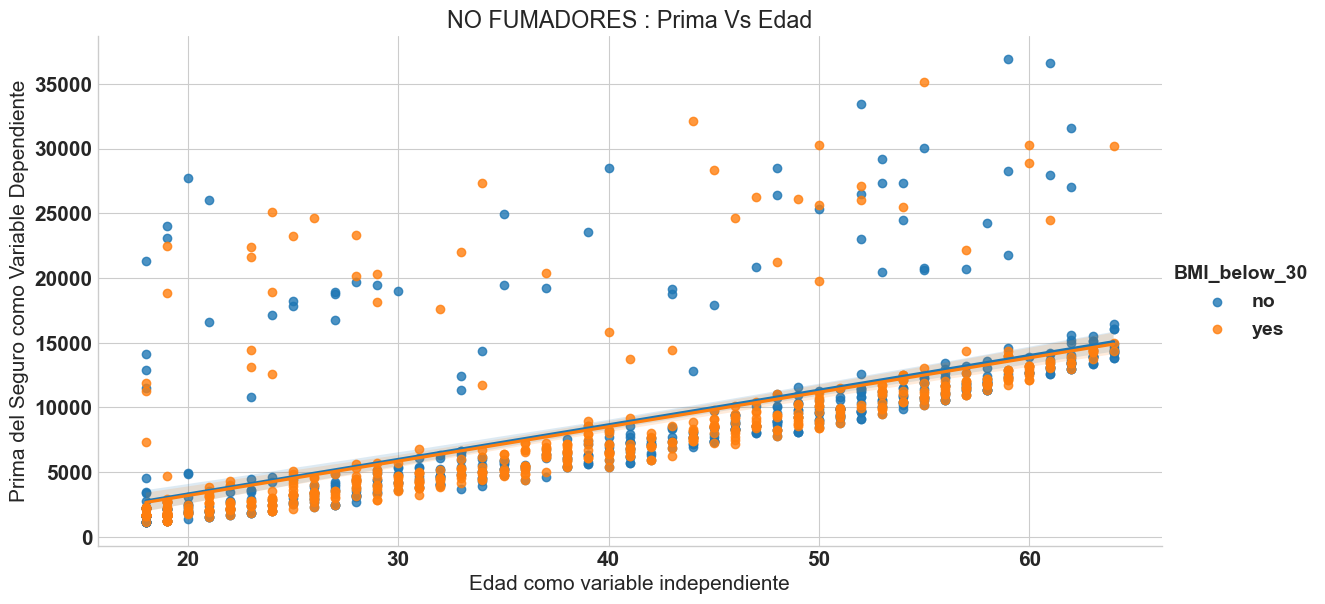

In [149]:
sns.lmplot(x='age',y='charges',hue='BMI_below_30',data=filter_no_smoker,aspect=2,height=6)
plt.xlabel('Edad como variable independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('NO FUMADORES : Prima Vs Edad');

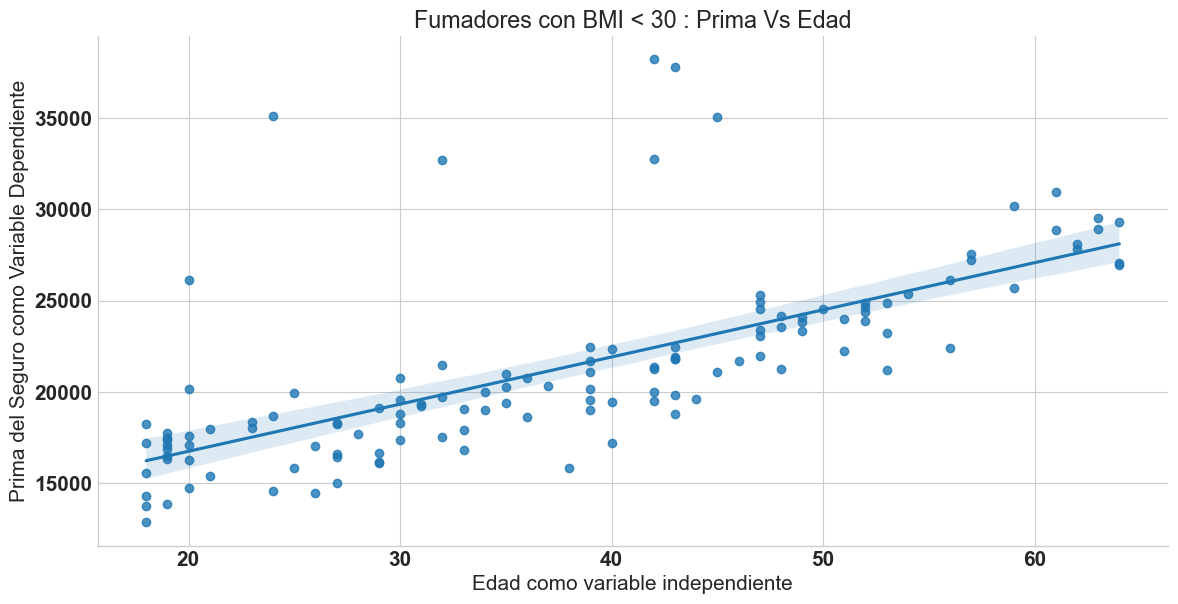

In [150]:
sns.lmplot(x='age',y='charges',data=below30_bmi,aspect=2,height=6)
plt.xlabel('Edad como variable independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores con BMI < 30 : Prima Vs Edad');

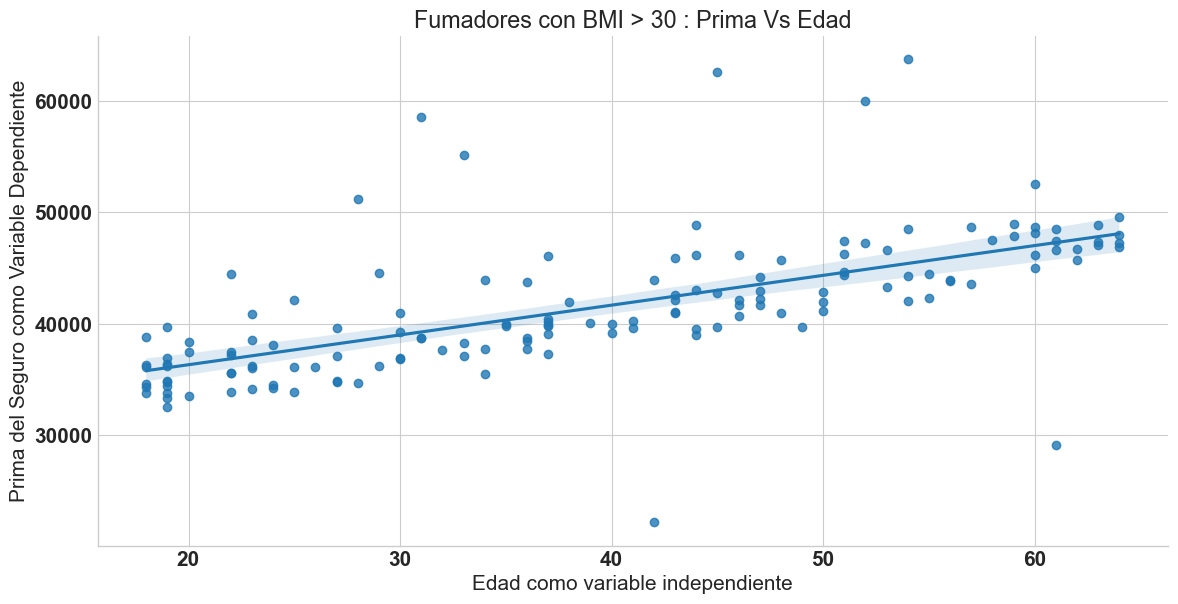

In [151]:
sns.lmplot(x='age',y='charges',data=upper30_bmi,aspect=2,height=6)
plt.xlabel('Edad como variable independiente')
plt.ylabel('Prima del Seguro como Variable Dependiente')
plt.title('Fumadores con BMI > 30 : Prima Vs Edad');

C:\Users\ruben.alvarezmosquer\AppData\Local\Temp\ipykernel_8316\1418005114.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insurance['charges'],bins=50,color='r',ax=ax)
C:\Users\ruben.alvarezmosquer\AppData\Local\Temp\ipykernel_8316\1418005114.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distp

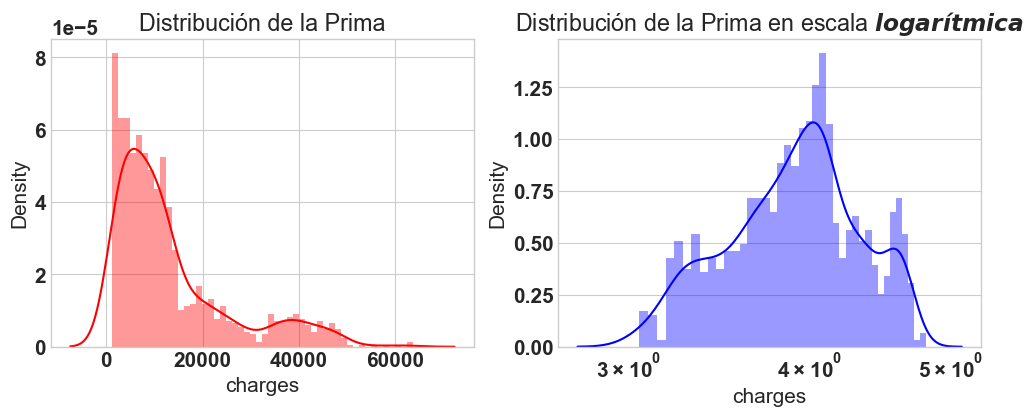

In [152]:
f= plt.figure(figsize=(12,4))

ax=f.add_subplot(121)
sns.distplot(insurance['charges'],bins=50,color='r',ax=ax)
ax.set_title('Distribución de la Prima')

ax=f.add_subplot(122)
sns.distplot(np.log10(insurance['charges']),bins=40,color='b',ax=ax)
ax.set_title('Distribución de la Prima en escala $logarítmica$')
ax.set_xscale('log');

Text(0.5, 1.0, 'Distribución de la Prima VS Hijos')

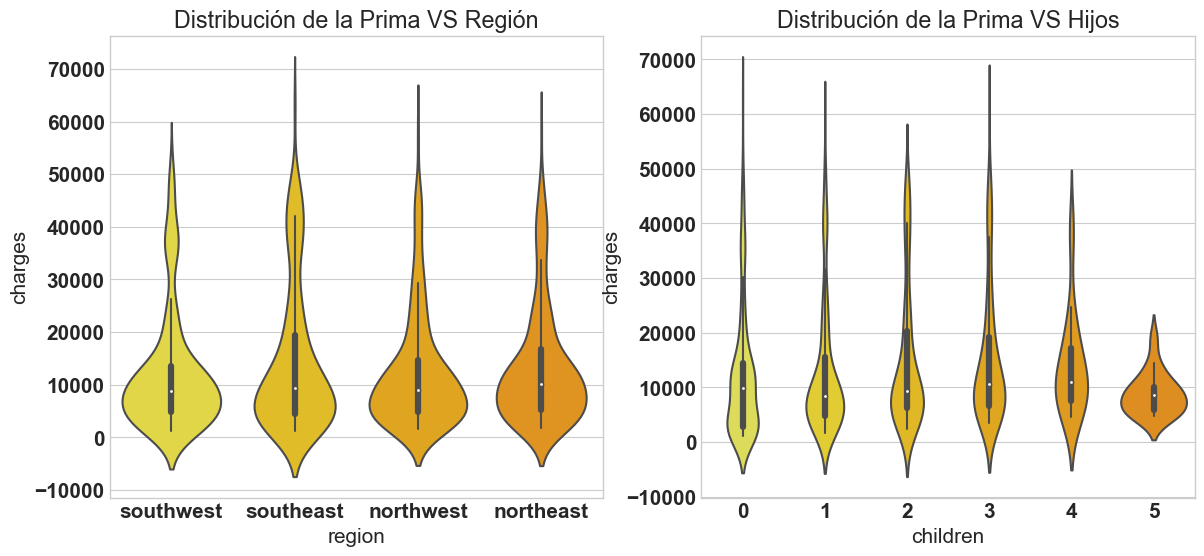

In [153]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(121)
sns.violinplot(x='region', y='charges',data=insurance,palette='Wistia',ax=ax)
ax.set_title('Distribución de la Prima VS Región')

ax = f.add_subplot(122)
sns.violinplot(x='children', y='charges',data=insurance,palette='Wistia',ax=ax)
ax.set_title('Distribución de la Prima VS Hijos')



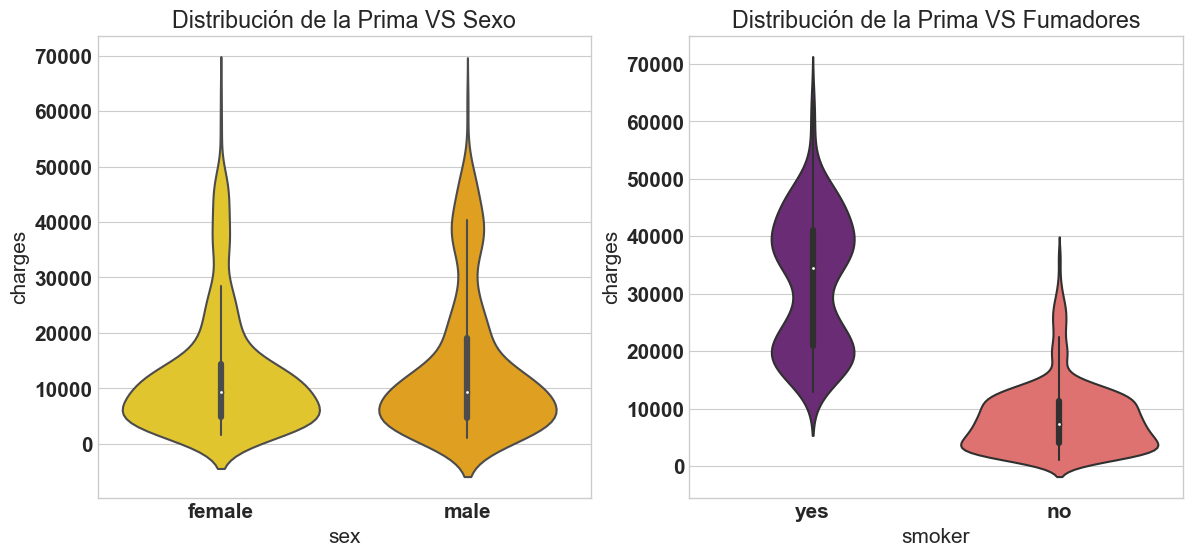

In [154]:
f = plt.figure(figsize=(14,6))

ax = f.add_subplot(121)
sns.violinplot(x='sex', y='charges',data=insurance,palette='Wistia',ax=ax)
ax.set_title('Distribución de la Prima VS Sexo')

ax = f.add_subplot(122)
sns.violinplot(x='smoker', y='charges',data=insurance,palette='magma',ax=ax)
ax.set_title('Distribución de la Prima VS Fumadores');




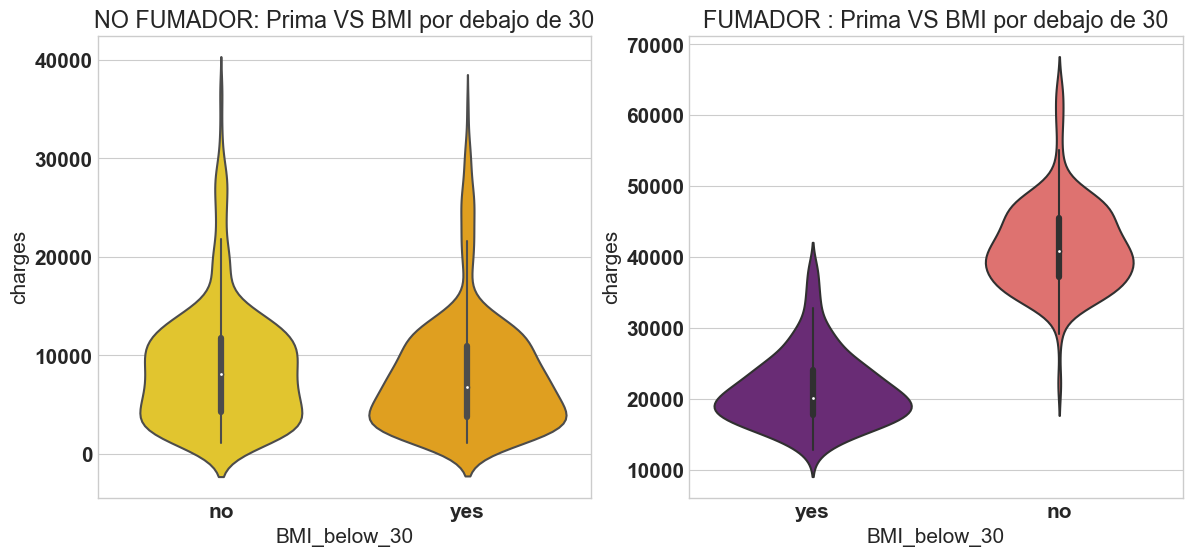

In [155]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(122)
sns.violinplot(x='BMI_below_30', y='charges',data=filter_smoker ,palette='magma',ax=ax)
ax.set_title('FUMADOR : Prima VS BMI por debajo de 30')

ax = f.add_subplot(121)
sns.violinplot(x='BMI_below_30', y='charges',data=filter_no_smoker ,palette='Wistia',ax=ax)
ax.set_title('NO FUMADOR: Prima VS BMI por debajo de 30');

---

---

---



# Seleccionando y entrenando los modelos

In [156]:
insurance.info()
insurance.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1338 non-null   float64
 1   sex           1338 non-null   object 
 2   bmi           1338 non-null   float64
 3   children      1338 non-null   int64  
 4   smoker        1338 non-null   object 
 5   region        1338 non-null   object 
 6   charges       1338 non-null   float64
 7   BMI_below_30  1338 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 83.8+ KB


,age,sex,bmi,children,smoker,region,charges,BMI_below_30
0,19.0,female,27.900,0,yes,southwest,16884.92400,yes
1,18.0,male,33.770,1,no,southeast,1725.55230,no
2,28.0,male,33.000,3,no,southeast,4449.46200,no
3,33.0,male,22.705,0,no,northwest,21984.47061,yes
4,32.0,male,28.880,0,no,northwest,3866.85520,yes


In [157]:
insurance_norm.info()
insurance_norm.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           1338 non-null   float64
 1   bmi           1338 non-null   float64
 2   children      1338 non-null   int64  
 3   charges       1338 non-null   float64
 4   female        1338 non-null   float64
 5   male          1338 non-null   float64
 6   no smoker     1338 non-null   float64
 7   smoker        1338 non-null   float64
 8   northeast     1338 non-null   float64
 9   northwest     1338 non-null   float64
 10  southeast     1338 non-null   float64
 11  southwest     1338 non-null   float64
 12  BMI_below_30  1338 non-null   int32  
dtypes: float64(11), int32(1), int64(1)
memory usage: 130.8 KB


,age,bmi,children,charges,female,male,no smoker,smoker,northeast,northwest,southeast,southwest,BMI_below_30
0,19.0,27.900,0,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1
1,18.0,33.770,1,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
2,28.0,33.000,3,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0
3,33.0,22.705,0,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1
4,32.0,28.880,0,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1


## Usaremos el modelo normalizado "insurance_norm"

## Creamos el Train y Test Set

In [158]:
# plantamos una semilla
np.random.seed(42)




In [159]:


def split_train_test(data, test_ratio):
    test_set_size  =int(len(insurance_norm)*test_ratio)
    shuffle_indices=np.random.permutation(len(data))
    test_indices   =shuffle_indices[:test_set_size]
    train_indices  =shuffle_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]
    




In [160]:

X_train, X_test = split_train_test(insurance_norm, 0.20)
len(X_train), len(X_test)

(1071, 267)

In [161]:
y_train = X_train["charges"].copy()

X_train = X_train.drop("charges", axis=1)

In [162]:

y_train


846      9872.70100
560      9193.83850
1285     8534.67180
1142    27117.99378
969      8596.82780
           ...     
1095     4561.18850
1130     8582.30230
1294    11931.12525
860     46113.51100
1126    10214.63600
Name: charges, Length: 1071, dtype: float64

## Entrenando y evaluando

In [163]:


from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)



LinearRegression()

Generamos las prediciones y las comparamos con los valores reales (sólo 10):

In [164]:

some_data = X_train.iloc[:5]
print("Predictions:", lin_reg.predict(some_data))

some_labels = y_train.iloc[:5]
print("Labels:", list(some_labels))



Predictions: [13016.65425518  7619.91834991  8012.68537187  8843.84801953
 11916.85561569]
Labels: [9872.701, 9193.8385, 8534.6718, 27117.99378, 8596.8278]


Error cuadrático medio:
$$ MSE = \frac{1}{n}∑_{i=1}^{n}{(y_i-y_i')}^2 $$

In [165]:


from sklearn.metrics import mean_squared_error

predictions = lin_reg.predict(X_train)
lin_mse = mean_squared_error(y_train, predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse




6031.7519680294

Error absoluto medio:
$$ MAE = \frac{1}{n}∑_{i=1}^{n}{|y_i-y_i'|} $$

In [166]:


from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(y_train, predictions)
lin_mae



4245.832766385122

---
---
---
---
---

# EXTRA : Otras regresiones

---

## Árbol de decisión

In [167]:


from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(X_train, y_train)



DecisionTreeRegressor()

In [168]:

predictions = tree_reg.predict(X_train)
tree_mse = mean_squared_error(y_train, predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse



493.97520812856715

## Mejorando la evaluación por medio de la validación cruzada

In [169]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores)
tree_rmse_scores


array([6433.95764222, 6595.87542749, 6644.50690481, 6967.42926535,
       7143.13855909, 6780.02824032, 7811.54629764, 7222.80328871,
       7299.46181862, 5730.3626797 ])

In [170]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean:   {scores.mean()}")
    print(f"Standard deviation:    {scores.std()}")
    
display_scores(tree_rmse_scores)



Scores: [6433.95764222 6595.87542749 6644.50690481 6967.42926535 7143.13855909
 6780.02824032 7811.54629764 7222.80328871 7299.46181862 5730.3626797 ]
Mean:   6862.911012396401
Standard deviation:    538.7025279240406


In [171]:
scores = cross_val_score(lin_reg, X_train, y_train, scoring = "neg_mean_squared_error", cv = 10)
lin_rmse_scores = np.sqrt(-scores)
lin_rmse_scores



array([6032.2789144 , 6660.16747787, 5081.28797415, 5840.54632493,
       5785.02281756, 5931.01820297, 7173.87553049, 6228.36704542,
       6198.31682186, 5731.88247293])

In [172]:
def display_scores(scores):
    print(f"Scores: {scores}")
    print(f"Mean:   {scores.mean()}")
    print(f"Standard deviation:    {scores.std()}")
    
display_scores(tree_rmse_scores)

Scores: [6433.95764222 6595.87542749 6644.50690481 6967.42926535 7143.13855909
 6780.02824032 7811.54629764 7222.80328871 7299.46181862 5730.3626797 ]
Mean:   6862.911012396401
Standard deviation:    538.7025279240406


**Note**: we specify `n_estimators=100` to be future-proof since the default value is going to change to 100 in Scikit-Learn 0.22 (for simplicity, this is not shown in the book).

In [173]:

from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators = 100, random_state=42)

forest_reg.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [174]:
predictions = forest_reg.predict(X_train)
forest_mse = mean_squared_error(y_train, predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse




1868.7512687394142

In [175]:

forest_scores = cross_val_score(forest_reg, X_train, y_train, scoring="neg_mean_squared_error", cv= 10)

forest_rmse_scores =  np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)


Scores: [4788.01542847 5317.8151682  3829.04182109 4499.20532009 5257.71370287
 5024.26150117 5778.22431894 5448.32617312 5132.18947957 4659.31694659]
Mean:   4973.410986012268
Standard deviation:    526.1165245270511


In [176]:
from sklearn.svm import SVR

svm_reg = SVR(kernel="linear")
svm_reg.fit(X_train, y_train)
predictions = svm_reg.predict(X_train)
svm_mse = mean_squared_error(y_train, predictions)
svm_rmse = np.sqrt(svm_mse)
svm_rmse

12790.621958923144

In [177]:


svm_scores = cross_val_score(svm_reg, X_train, y_train, scoring="neg_mean_squared_error", cv= 10)

svm_rmse_scores =  np.sqrt(-forest_scores)
display_scores(svm_rmse_scores)


Scores: [4788.01542847 5317.8151682  3829.04182109 4499.20532009 5257.71370287
 5024.26150117 5778.22431894 5448.32617312 5132.18947957 4659.31694659]
Mean:   4973.410986012268
Standard deviation:    526.1165245270511


## XGBoost

In [179]:
# "xgboost" algoritmo similar a random forest, pero 
# en vez de hacerlo en paralelo, lo hace en serie
# pasando la salida con la entrada del siguiente, 
# puliendo el resultado

import xgboost as xgb

xgb_reg = xgb.XGBRegressor(objetive= "reg:squarederror", random_state=42)

xgb_reg.fit(X_train, y_train)
predictions=xgb_reg.predict(X_train)
xgb_mse=mean_squared_error(y_train, predictions)
xgb_rmse=np.sqrt(xgb_mse)
xgb_mse

[19:00:58] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objetive" } are not used.



940062.6570899304

In [181]:
xgb_scores = cross_val_score(xgb_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10)
xgb_rmse_scores = np.sqrt(-xgb_scores)
display_scores(xgb_rmse_scores)

[19:01:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objetive" } are not used.

[19:01:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objetive" } are not used.

[19:01:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objetive" } are not used.

[19:01:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objetive" } are not used.

[19:01:15] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objetive" } are not used.

[19:01:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objetive" } are not used.

[19:01:16] WARNING: C:\Users\dev-admin\croot2\xgboost-split_1675461376218\work\src\learner.cc:767: 
Parameters: { "objetive" } are not used.

[19:01

# Evaluando el modelo con el Test Set

In [182]:
y_test = X_test["charges"].copy()
X_test = X_test.drop("charges", axis=1)


In [183]:
predictions = tree_reg.predict(X_test)

final_mse = mean_squared_error(y_test, predictions)
final_rmse = np.sqrt(final_mse)
final_rmse

6440.730105634658